# Use an scVI run to created "de-batched" count data for use downstream

2024.04.26

Run scVI using Cellarium ML and explore the outputs.

In [1]:
# your config file for running scVI

config_file = "../example_configs/scvi_pbmc_config.yaml"

## Run scVI

In [ ]:
!cellarium-ml scvi fit --config {config_file}

## Load model

In [2]:
# your latest checkpoint file (you'll need to look for it)

checkpoint_file = "../lightning_logs/version_31/checkpoints/epoch=49-step=3150.ckpt"

In [3]:
import tempfile

import anndata
import matplotlib.pyplot as plt
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import torch
import tqdm
import umap
import yaml

from cellarium.ml.core import CellariumModule, CellariumPipeline
from cellarium.ml.data import (
    DistributedAnnDataCollection,
    IterableDistributedAnnDataCollectionDataset,
)
from cellarium.ml.data.fileio import read_h5ad_file
from cellarium.ml.utilities.data import AnnDataField, categories_to_codes, densify

%matplotlib inline

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [4]:
# load the trained model
scvi_model = CellariumModule.load_from_checkpoint(checkpoint_file).model

# move the model to the correct device
device = "cuda" if torch.cuda.is_available() else "cpu"
scvi_model.to(device)
scvi_model.eval()

# construct the pipeline
pipeline = CellariumPipeline([scvi_model])

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [5]:
class AutosizedDistributedAnnDataCollection(DistributedAnnDataCollection):
    def __init__(self, *args, **kwargs):
        # I'm being lazy here and doing something real ugly
        # I want it to take the shard_size from the first file
        try:
            # this allows super to find the list of filenames
            super().__init__(*args, **kwargs)
        except AssertionError:
            try:
                # this allows super to create the cache
                kwargs.pop("shard_size")
                kwargs = kwargs | {"shard_size": 10000}
                super().__init__(*args, **kwargs)
            except AssertionError:
                pass
            # load first file and cache it
            adata0 = self.cache[self.filenames[0]] = read_h5ad_file(self.filenames[0])
            # pull shard_size from that file
            kwargs.pop("shard_size")
            kwargs = kwargs | {"shard_size": len(adata0)}
            # finally initialize for real
            super().__init__(*args, **kwargs)


def get_dataset_from_anndata(
    adata: anndata.AnnData | str,
    batch_size: int = 128,
    shard_size: int | None = None,
    shuffle: bool = False,
    seed: int = 0,
    drop_last: bool = False,
):
    """
    Get IterableDistributedAnnDataCollectionDataset from an AnnData object or h5ad file specifier.

    Args:
        adata: AnnData object or h5ad file, allowing brace notation for several files.
        batch_size: Batch size.
        shard_size: Shard size.
        shuffle: Whether to shuffle the dataset.
        seed: Random seed.
        drop_last: Whether to drop the last incomplete batch.

    Returns:
        IterableDistributedAnnDataCollectionDataset.
    """

    if isinstance(adata, anndata.AnnData):
        tmpfile = tempfile.mkstemp(suffix=".h5ad")
        adata.write(tmpfile[1])
        file = tmpfile[1]
    else:
        file = adata

    dadc = AutosizedDistributedAnnDataCollection(
        file,
        shard_size=shard_size,
        max_cache_size=1,
    )

    dataset = IterableDistributedAnnDataCollectionDataset(
        dadc,
        batch_keys={
            "x_ng": AnnDataField(attr="X", convert_fn=densify),
            "var_names_g": AnnDataField(attr="var_names"),
            "batch_index_n": AnnDataField(attr="obs", key="batch", convert_fn=categories_to_codes),
        },
        batch_size=batch_size,
        shuffle=shuffle,
        seed=seed,
        drop_last=drop_last,
    )
    return dataset

In [6]:
# get the location of the dataset
with open(config_file, "r") as file:
    config_dict = yaml.safe_load(file)
data_path = config_dict["data"]["dadc"]["init_args"]["filenames"]
print(f"Data is coming from {data_path}")

# get a dataset object
dataset = get_dataset_from_anndata(
    data_path,
    batch_size=128,
    shuffle=False,
    seed=0,
    drop_last=False,
)

Data is coming from gs://yx-data/pbmc_count.h5ad


In [7]:
def reconstruct_debatched(
    dataset: IterableDistributedAnnDataCollectionDataset,
    pipeline: CellariumPipeline,
    transform_to_batch_label: int,
    maximum_anndata_files_to_download: int = 5,
    layer_key_added: str = "scvi_reconstructed",
) -> anndata.AnnData:
    """
    Reconstruct the dataset using the pipeline.

    Args:
        dataset: Dataset.
        pipeline: Pipeline.
        transform_to_batch_label: batch label to reconstruct as
        maximum_anndata_files_to_download: Maximum number of anndata files to download.
        layer_key_added: Output counts will be stored in adata.layers[layer_key_added]

    Returns:
        AnnData with scVI reconstruction in adata.layers[layer_key_added]
    """

    # get the anndata object
    adatas = [
        dataset.dadc.adatas[i].adata for i in range(min(maximum_anndata_files_to_download, len(dataset.dadc.adatas)))
    ]
    adata = anndata.concat(adatas, axis=0, merge="same")

    scvi_model = pipeline[-1]

    # run the pipeline
    sparse_coos = []
    with torch.no_grad():
        for batch in tqdm.tqdm(dataset):
            batch["x_ng"] = torch.from_numpy(batch["x_ng"]).to(device)
            batch["batch_index_n"] = torch.from_numpy(batch["batch_index_n"]).to(device)
            # out = pipeline.predict(batch)
            counts_ng = scvi_model.reconstruct(
                x_ng=batch["x_ng"],
                var_names_g=batch["var_names_g"],
                batch_index_n=batch["batch_index_n"],
                transform_batch=transform_to_batch_label,
                sample=True,
            )
            sparse_coos.append(sp.coo_matrix(counts_ng.cpu().numpy()))

    # make the final sparse matrix and keep it as a layer
    csr = sp.vstack(sparse_coos).tocsr()
    adata.layers[layer_key_added] = csr

    return adata

In [9]:
adata = None

for label in range(pipeline[-1].n_batch):
    adata_tmp = reconstruct_debatched(
        dataset,
        pipeline,
        transform_to_batch_label=label,
        layer_key_added=f"scvi_reconstructed_{label}",
    )
    if adata is None:
        adata = reconstruct_debatched(
            dataset,
            pipeline,
            transform_to_batch_label=label,
            layer_key_added=f"scvi_reconstructed_{label}",
        )
    else:
        adata.layers[f"scvi_reconstructed_{label}"] = adata_tmp.layers[f"scvi_reconstructed_{label}"]
    break

/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has not been initialized. Falling back to ``rank=0`` and ``num_replicas=1``.
  warnings.warn(
  0%|          | 0/249 [00:00<?, ?it/s]/tmp/ipykernel_30401/2311162174.py:33: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  batch['batch_index_n'] = torch.from_numpy(batch['batch_index_n']).to(device)
100%|██████████| 249/249 [00:11<00:00, 22.45it/s]
/home/sfleming/cellarium-ml/cellarium/ml/utilities/data.py:99: UserWarning: Distributed package is available but the default process group has no

In [10]:
adata.layers["raw"] = adata.X.copy()

In [11]:
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'
    layers: 'scvi_reconstructed_0', 'raw'

In [12]:
gene_set = "MIR892B,MIR873,USH1C,CTDSP2,RAD50,FEM1B,CDK2,CDK3,CDK4,PSME3,CDK5,CDK6,CTDSPL,CDK7,CDKN1A,CDK2AP2,CDKN1B,AKAP8,CDKN1C,CDKN2A,CDKN2B,CCNO,CDKN2C,CDKN2D,CDKN3,NPM2,BTN2A2,NDC80,GPNMB,MAD2L2,TACC3,UBD,CENPE,CENPF,KHDRBS1,NES,PLK2,ARPP19,NEK6,DBF4,CCNI,RCC1,PIM2,UBE2C,TOPBP1,CHEK1,FOXN3,ZWINT,FAM107A,CHEK2,TREX1,CDCA5,ECD,PHB2,PABIR1,CKS1B,CKS2,PRAP1,DCUN1D3,PLK3,PLK5,IQGAP3,CHMP4B,TRIM71,TPRA1,LSM11,HUS1B,NACC2,ATF2,CRY1,MAPK14,CACUL1,E2F7,RAD9B,EME1,SPC24,DTX3L,NEK10,CYP1A1,SASS6,SDE2,DDB1,DDX3X,CDC14C,DLG1,DNA2,DNM2,DUSP1,E2F1,E2F2,E2F3,E2F4,E2F6,EGFR,ARID2,EME2,EIF4E,EIF4EBP1,EIF4G1,AIF1,ENSA,EPS8,ERCC2,AKT1,ERCC3,ERCC6,ESRRB,EZH2,FANCD2,STOX1,CCNY,FGF10,MAPK15,FHL1,ATF5,SIRT2,PAXIP1,MYO16,FOXM1,CLASP2,PHF8,SMC5,FBXL7,PLCB1,KLHL18,CLASP1,UFL1,BRD4,SPDYA,STXBP4,MBLAC1,FBXO7,ZNF324,INTS7,ANAPC15,SIN3A,SYF2,KANK2,HINFP,ANKRD17,GIGYF2,APPL1,TIPRL,FBXO6,FBXO5,FBXO4,LATS2,GFI1,AKAP8L,MTBP,KCNH5,VPS4A,CHMP2A,UBE2S,PRPF19,GLI1,GML,CCDC57,NSMCE2,RGCC,BABAM1,BRD7,GSPT1,TMOD3,ANAPC2,GPR132,RPA4,ANAPC4,DONSON,NOP53,ANXA1,H2AX,APBB1,APBB2,APC,PRMT2,HSPA2,BIRC5,HUS1,HYAL1,ID2,ID4,GEN1,APP,IK,INCENP,INHBA,ITGB1,KCNA5,USP17L2,GPR15LG,NANOGP8,MIR10A,MIR133A1,MIR137,MIR15A,MIR15B,MIR16-1,MIR193A,MIR195,MIR19B1,MIR208A,MIR214,MIR221,MIR222,MIR26A1,MIR29A,MIR29B1,MIR29C,MIR30C2,MAD2L1,MDM2,MECP2,MLF1,MAP3K11,FOXO4,MN1,MNAT1,MOS,MRE11,EIF2AK4,MIR133B,MIR372,MSH2,MUC1,MYC,NBN,ATM,NEUROG1,NFIA,NFIB,NPAT,NPM1,DDR2,ATP2B4,CRNN,ORC1,OVOL1,RRM2B,PBX1,RPS27L,DYNC1LI1,ING4,MRNIP,CDK16,TFDP3,CDK17,CDK18,WAC,DACT1,FZR1,TAOK3,MBTPS2,CRLF3,PPME1,ACTL6B,ANAPC5,ANAPC7,LCMT1,TRIAP1,GTSE1,DTL,ANAPC11,SIRT7,METTL13,CPSF3,UIMC1,MAP3K20,CDK14,ABCB1,PKD1,PKD2,PLCG2,PLK1,PLRG1,PML,POLE,ANLN,ETAA1,ATR,INO80,CCNJ,PAF1,NSUN2,SPDL1,TIPIN,PINX1,USP47,ZWILCH,PPP1R10,CDCA8,PPP2CA,RFWD3,PBRM1,APPL2,PHF10,FBXW7,PPP3CA,PIDD1,PPP6C,AMBRA1,PKIA,CHFR,CDK5RAP2,RIOK2,PCID2,CENPJ,PPP2R2D,KMT2E,PRKDC,RCC2,TEX14,SUSD2,MEPCE,PROX1,TRIM39,TCIM,PSMG2,KNL1,AVEN,BACH1,GJC2,PSME1,PSME2,PTEN,MIR362,SPC25,MIR451A,MIR495,MIR515-1,MIR520A,MIR519D,MIR520H,MIR503,ARID1B,MTA3,HECW2,RPTOR,TAOK1,USP28,CAMSAP3,USP29,USP37,PTPN6,CCAR2,PTPN11,PTPRC,BARD1,RAD1,CTDSP1,RHOU,INIP,BCAT1,RAD9A,RAD17,RAD21,RAD51,RAD51C,RAD51B,RB1,RBBP8,RBL1,RBL2,CCND1,BCL2,RDX,UPF1,DPF2,RFPL1,ACTB,BCL7A,RINT1,MIIP,RPA2,RPL24,RPL26,RPS6,RPS6KB1,RRM1,RRM2,CCL2,BID,CLSPN,BLM,SETMAR,CCNI2,ANAPC1,NABP1,STIL,SIX3,SKP2,CDK15,INTS3,SMARCA2,SMARCA4,STK33,SMARCB1,SMARCC1,DDRGK1,SMARCC2,SMARCD1,SMARCD2,SMARCD3,SMARCE1,SOX2,SPAST,BRCA1,BRCA2,ZFP36L1,ZFP36L2,AURKA,ADAM17,TAF1,TAF2,TAF10,TBX2,MIR638,BUB1,BUB1B,TERT,TFAP4,TFDP1,TP53,TP53BP1,TPD52L1,TPR,TTK,UBE2A,UBE2E2,UBE2L3,WEE1,WNT10B,XPC,XRCC3,ZNF16,ZNF207,CACNB4,ZNF655,NABP2,FBXL15,BRCC3,DDX39B,PAGR1,CDC73,CCNJL,RNASEH2B,FBXO31,KDM8,NEK11,ATAD5,CCNP,JADE1,WDR76,CALM1,CTC1,DBF4B,TTI2,MUS81,CEP63,CDK5RAP3,CALM2,CUL5,CALM3,DPF3,CAMK2A,FAM83D,CDT1,TMEM14B,DPF1,ARID1A,CDC7,CDC45,GFI1B,CASP2,NUF2,PARP9,RHNO1,MAD1L1,USP26,HASPIN,BRIP1,HORMAD1,USP44,ATRIP,ABRAXAS1,DYRK3,DOT1L,BRSK1,CUL4B,CUL4A,CUL3,CUL2,CUL1,KLF11,PPP1R9B,KLHL22,PPM1D,MASTL,ZFYVE19,LSM10,CCNB3,PIAS1,CDC14B,CDC14A,CDK10,THOC5,ACTL6A,CDC23,MBTPS1,CRADD,RAB11A,IER3,CDC16,ZPR1,NAE1,CCNA2,CCNA1,CCNB1,TIMELESS,PHOX2B,CCND2,CCND3,CCNE1,CCNF,ACVR1,CCNG1,CCNG2,CCNH,BRSK2,TM4SF5,TICRR,PKMYT1,ACVR1B,LATS1,CCNB2,CCNE2,CTDP1,ZNF830,SLFN11,CHMP7,ZW10,BUB3,CCNQ,AURKB,CHMP4C,BCL7C,BCL7B,KLF4,TRIP13,TAOK2,ADAMTS1,VPS4B,MACROH2A1,CLOCK,BABAM2,MAD2L1BP,MDC1,TTI1,ESPL1,KNTC1,DLGAP5,CDK1,MELK,CDC5L,TELO2,CDC6,CDC20,KIF14,CDC25A,CDC25B,CDC25C,CDC27,CDC34,THOC1".split(  # noqa: E501
    ","
)
gene_set = np.array(gene_set)
gene_set

array(['MIR892B', 'MIR873', 'USH1C', 'CTDSP2', 'RAD50', 'FEM1B', 'CDK2',
       'CDK3', 'CDK4', 'PSME3', 'CDK5', 'CDK6', 'CTDSPL', 'CDK7',
       'CDKN1A', 'CDK2AP2', 'CDKN1B', 'AKAP8', 'CDKN1C', 'CDKN2A',
       'CDKN2B', 'CCNO', 'CDKN2C', 'CDKN2D', 'CDKN3', 'NPM2', 'BTN2A2',
       'NDC80', 'GPNMB', 'MAD2L2', 'TACC3', 'UBD', 'CENPE', 'CENPF',
       'KHDRBS1', 'NES', 'PLK2', 'ARPP19', 'NEK6', 'DBF4', 'CCNI', 'RCC1',
       'PIM2', 'UBE2C', 'TOPBP1', 'CHEK1', 'FOXN3', 'ZWINT', 'FAM107A',
       'CHEK2', 'TREX1', 'CDCA5', 'ECD', 'PHB2', 'PABIR1', 'CKS1B',
       'CKS2', 'PRAP1', 'DCUN1D3', 'PLK3', 'PLK5', 'IQGAP3', 'CHMP4B',
       'TRIM71', 'TPRA1', 'LSM11', 'HUS1B', 'NACC2', 'ATF2', 'CRY1',
       'MAPK14', 'CACUL1', 'E2F7', 'RAD9B', 'EME1', 'SPC24', 'DTX3L',
       'NEK10', 'CYP1A1', 'SASS6', 'SDE2', 'DDB1', 'DDX3X', 'CDC14C',
       'DLG1', 'DNA2', 'DNM2', 'DUSP1', 'E2F1', 'E2F2', 'E2F3', 'E2F4',
       'E2F6', 'EGFR', 'ARID2', 'EME2', 'EIF4E', 'EIF4EBP1', 'EIF4G1',
       'AIF1', 

In [24]:
adata.var.head()

,genes_of_interest
index,
TCL1A,False
IGLL5,False
FGFBP2,False
PTGDS,False
GZMB,False


In [25]:
adata.var["expr"] = np.array(adata.layers["raw"].sum(axis=0)).squeeze()

In [26]:
adata.var.head()

,genes_of_interest,expr
index,,
TCL1A,False,13669.0
IGLL5,False,7995.0
FGFBP2,False,12012.0
PTGDS,False,6112.0
GZMB,False,19888.0


In [27]:
adata.var[adata.var["genes_of_interest"]].sort_values(by="expr")

,genes_of_interest,expr
index,,
BRSK2,True,22.0
NFIB,True,43.0
HORMAD1,True,86.0
DDR2,True,105.0
ADAMTS1,True,135.0
...,...,...
ID2,True,40666.0
ZFP36L1,True,42891.0
AIF1,True,90059.0


In [40]:
high_gene_set = adata.var.sort_values(by="expr").index[-50:]
low_gene_set = adata.var.sort_values(by="expr").index[:500]

In [41]:
high_gene_set

Index(['MCL1', 'LST1', 'CCL5', 'MNDA', 'ITGB2', 'HIST1H4C', 'TUBB', 'NFKBIA',
       'FCER1G', 'VCAN', 'TSPO', 'GSTP1', 'NKG7', 'PSAP', 'AIF1', 'S100A11',
       'BLVRB', 'ANXA1', 'FCN1', 'GNLY', 'ZFP36', 'IL32', 'HMGB2', 'KLF6',
       'IER2', 'COTL1', 'S100A12', 'HLA-DPB1', 'JUND', 'HLA-DRB1', 'SAT1',
       'FOSB', 'HLA-DPA1', 'TYROBP', 'TUBA1B', 'LGALS1', 'CST3', 'SRGN', 'LTB',
       'CTSS', 'JUN', 'DUSP1', 'HLA-DRA', 'NEAT1', 'CD74', 'FOS', 'S100A8',
       'LYZ', 'S100A9', 'HBA1'],
      dtype='object', name='index')

In [13]:
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'
    layers: 'scvi_reconstructed_0', 'raw'

# Visualizations

In [14]:
sc.set_figure_params(fontsize=14, vector_friendly=True)

## Before scVI

In [15]:
for layer in adata.layers.keys():
    if not layer.startswith("scvi_reconstructed"):
        continue

    print(f"working on {layer}")
    adata.X = adata.layers[layer].copy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.pca(adata)
    sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric="euclidean", method="umap")
    sc.tl.umap(adata)
    adata.obsm[f"X_{layer}_umap"] = adata.obsm["X_umap"].copy()

working on scvi_reconstructed_0


In [16]:
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_scvi_reconstructed_0_umap'
    varm: 'PCs'
    layers: 'scvi_reconstructed_0', 'raw'
    obsp: 'distances', 'connectivities'

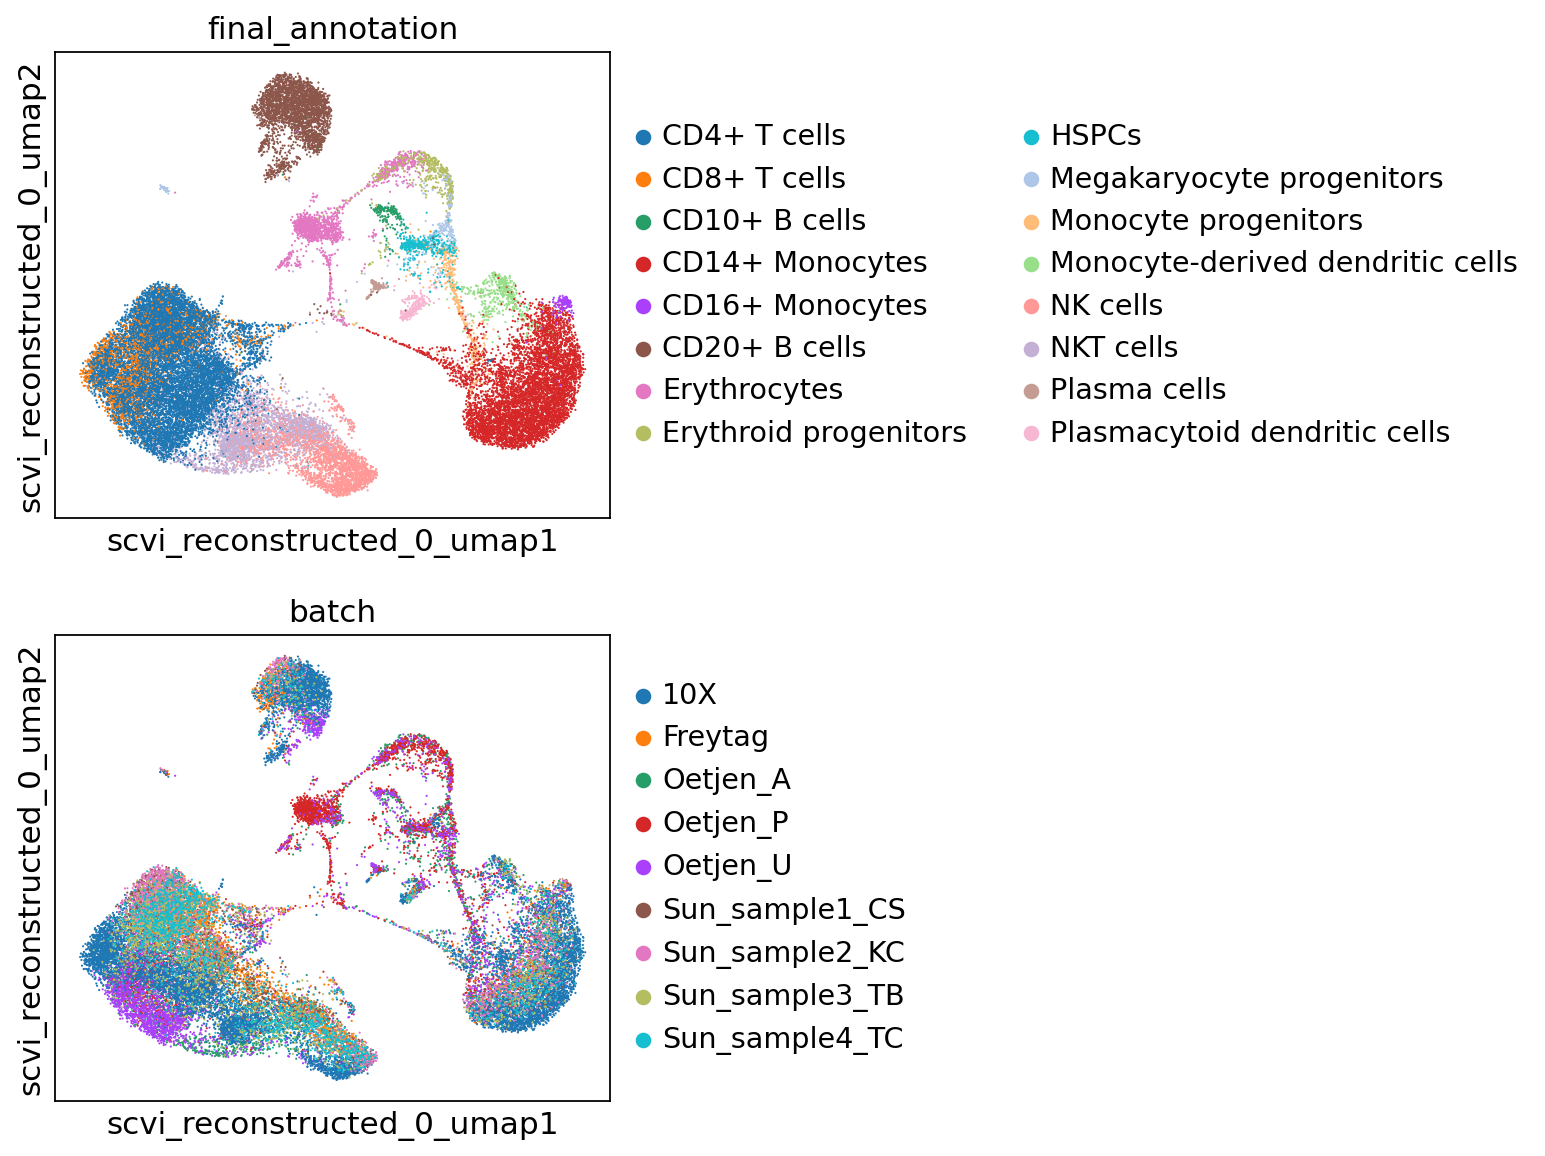

In [17]:
sc.pl.embedding(adata, basis="scvi_reconstructed_0_umap", color=["final_annotation", "batch"], ncols=1)

In [42]:
adata.var["low_exp_genes_of_interest"] = adata.var_names.isin(low_gene_set)
adata.var["high_exp_genes_of_interest"] = adata.var_names.isin(high_gene_set)
adata.var["genes_of_interest"] = adata.var_names.isin(gene_set)

In [43]:
adata.var["high_exp_genes_of_interest"].sum()

50

In [46]:
for layer in adata.layers.keys():
    if not layer.startswith("scvi_reconstructed"):
        continue

    print(f"working on {layer}")
    adata.X = adata.layers[layer].copy()

    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)
    sc.pp.pca(adata, mask_var="high_exp_genes_of_interest")
    sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric="euclidean", method="umap")
    sc.tl.umap(adata)
    adata.obsm[f"X_{layer}_geneset_umap"] = adata.obsm["X_umap"].copy()

    break

working on scvi_reconstructed_0


In [47]:
adata

AnnData object with n_obs × n_vars = 31774 × 4000
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue', 'condition', 'concat'
    var: 'genes_of_interest', 'expr', 'low_exp_genes_of_interest', 'high_exp_genes_of_interest'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'final_annotation_colors', 'batch_colors'
    obsm: 'X_pca', 'X_umap', 'X_scvi_reconstructed_0_umap', 'X_scvi_reconstructed_0_geneset_umap', 'X_raw_umap'
    varm: 'PCs'
    layers: 'scvi_reconstructed_0', 'raw'
    obsp: 'distances', 'connectivities'

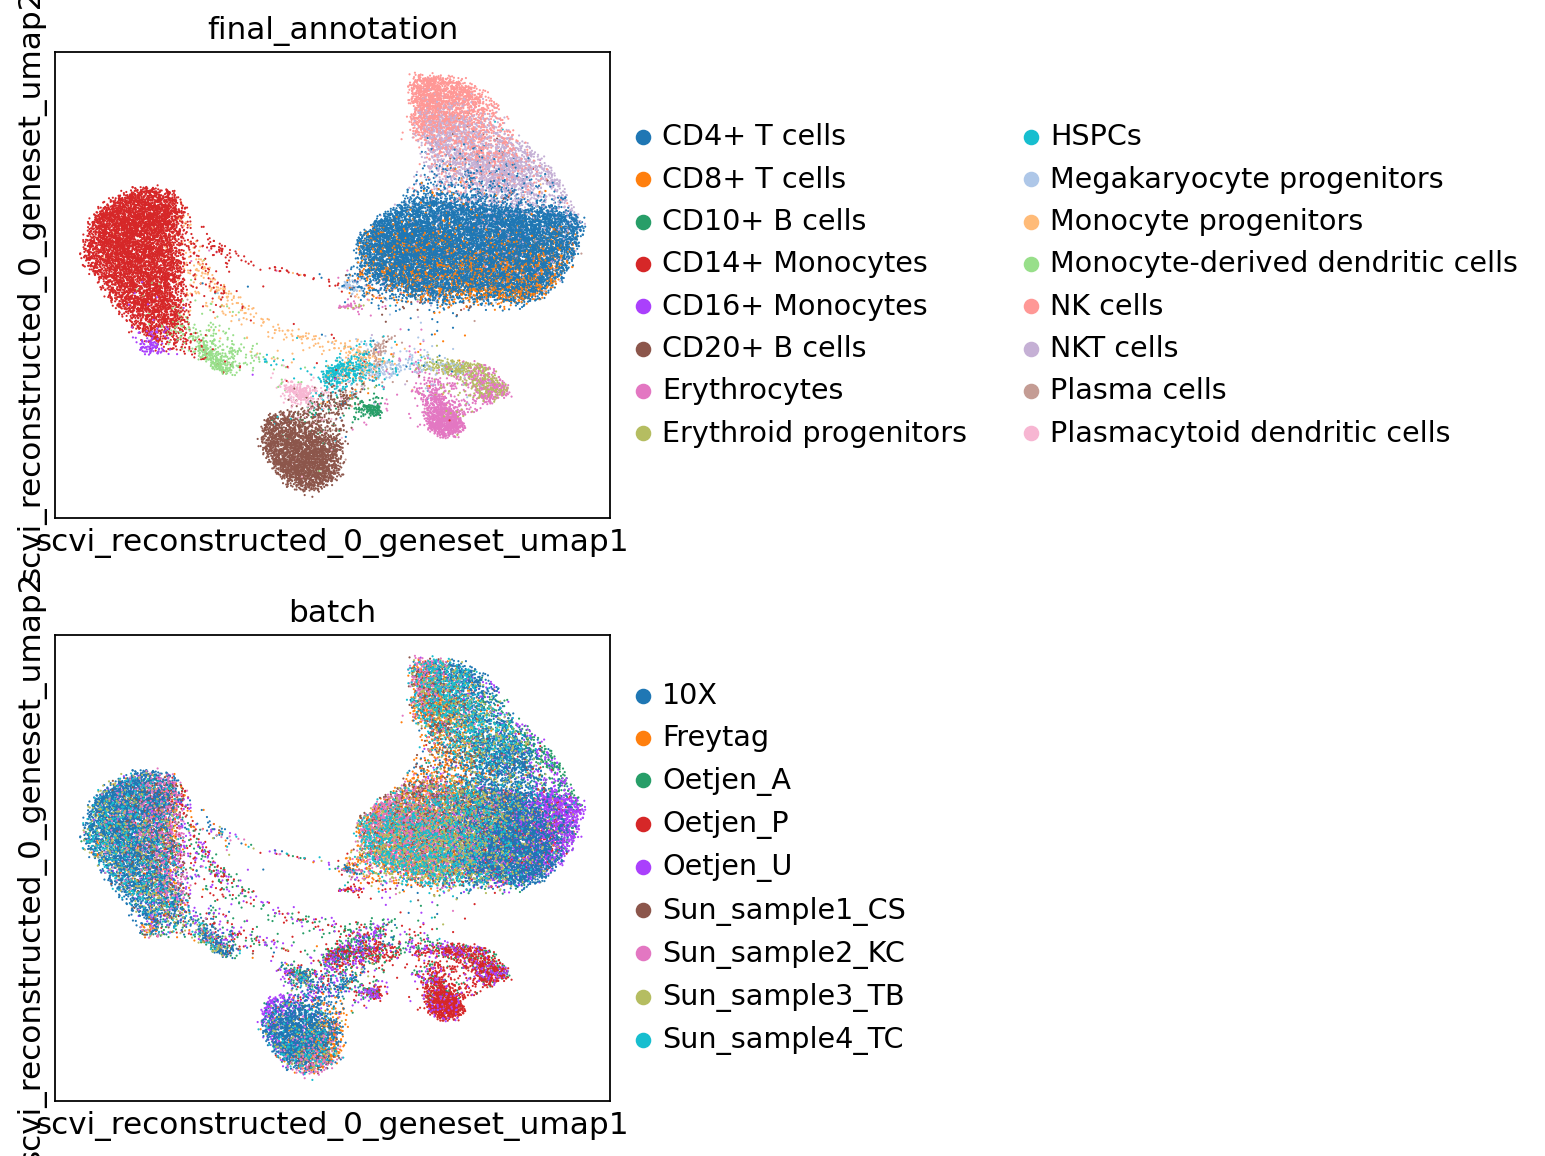

In [48]:
sc.pl.embedding(adata, basis="scvi_reconstructed_0_geneset_umap", color=["final_annotation", "batch"], ncols=1)

In [44]:
# true raw data run

adata.X = adata.layers["raw"].copy()

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.pca(adata, mask_var="high_exp_genes_of_interest")
sc.pp.neighbors(adata, n_pcs=20, n_neighbors=15, metric="euclidean", method="umap")
sc.tl.umap(adata)
adata.obsm["X_raw_umap"] = adata.obsm["X_umap"].copy()

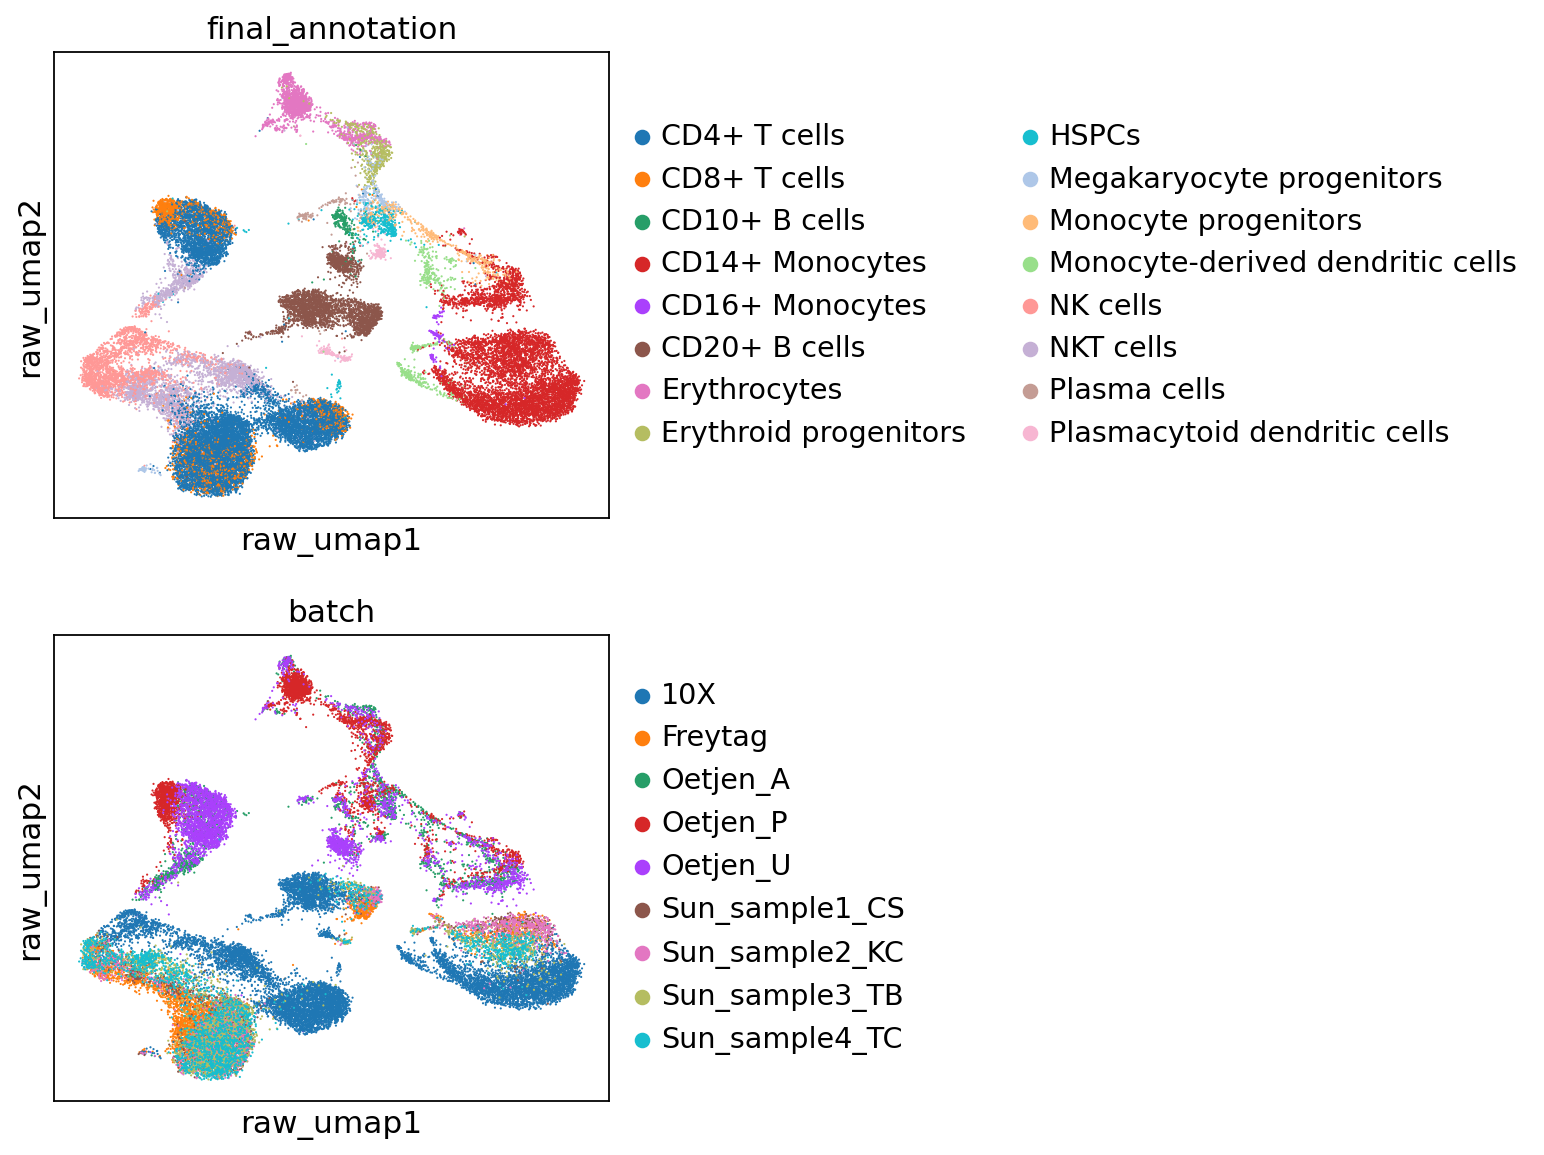

In [45]:
sc.pl.embedding(adata, basis="raw_umap", color=["final_annotation", "batch"], ncols=1)

/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sfleming/miniforge3/envs/cellarium/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


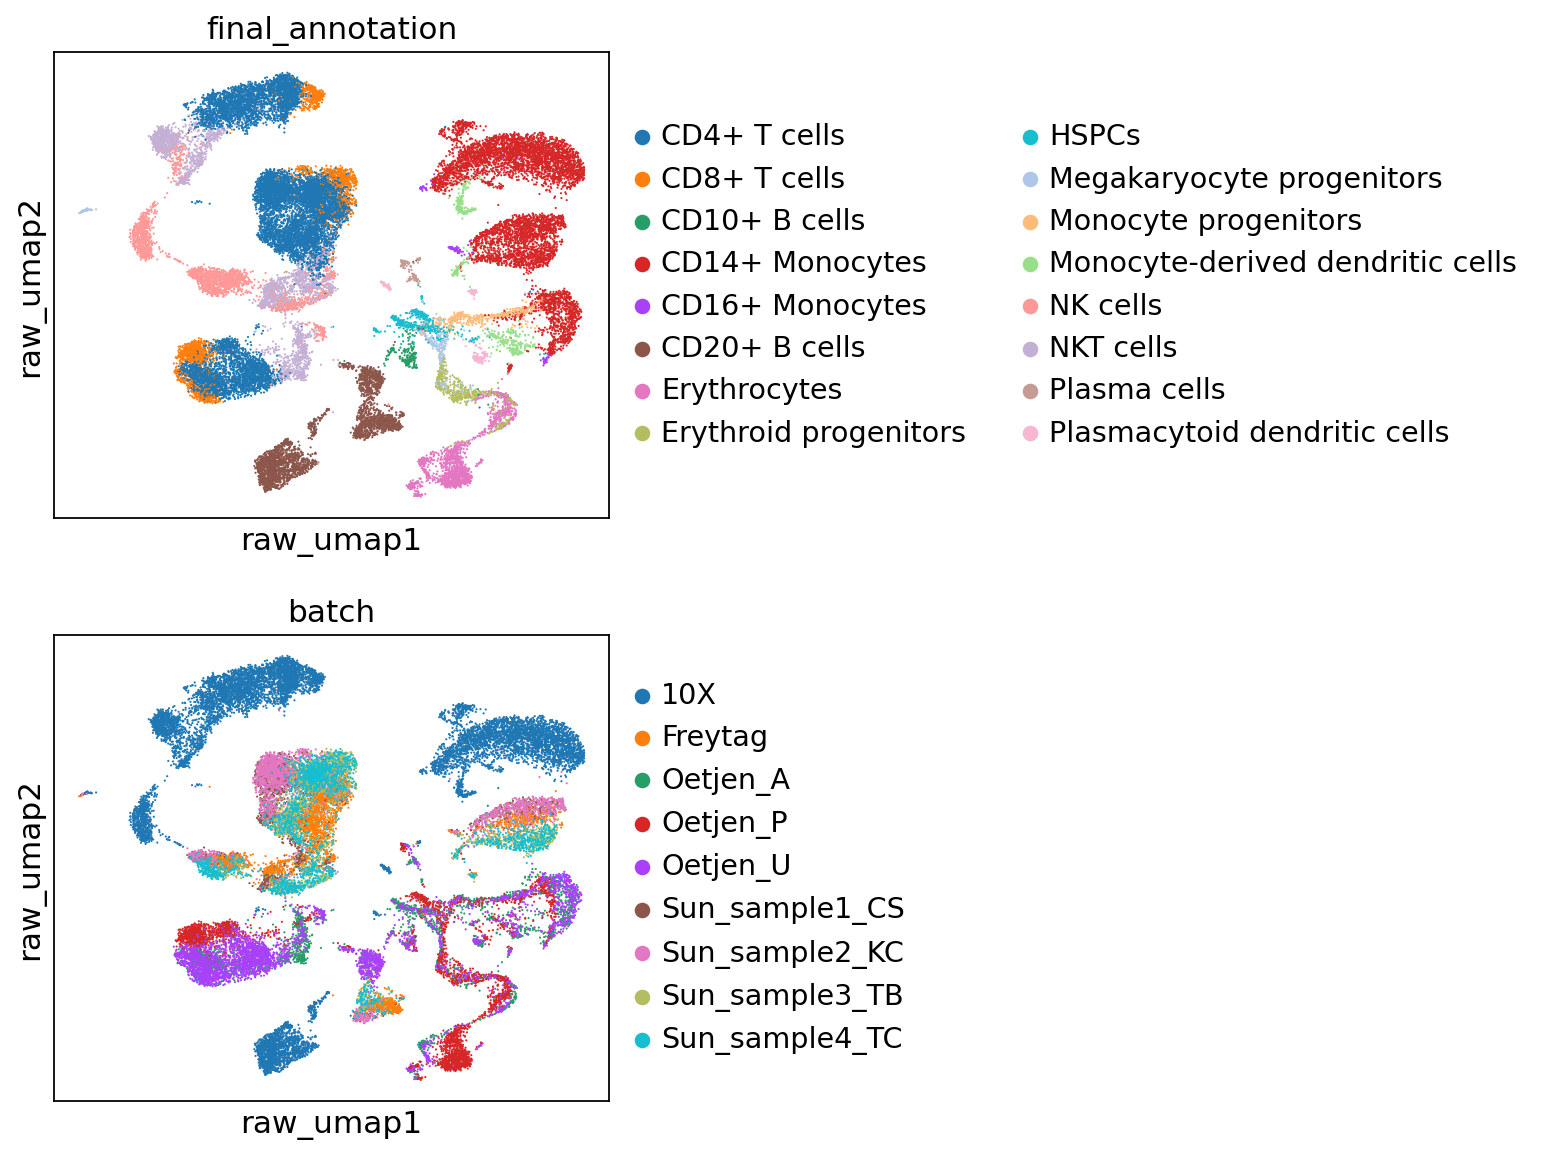

In [ ]:
sc.pl.embedding(adata, basis="raw_umap", color=["final_annotation", "batch"], ncols=1)

## After scVI

In [11]:
sc.pp.neighbors(adata, use_rep="X_scvi", n_neighbors=15, metric="euclidean", method="umap")
sc.tl.umap(adata)
adata.obsm["X_scvi_umap"] = adata.obsm["X_umap"].copy()

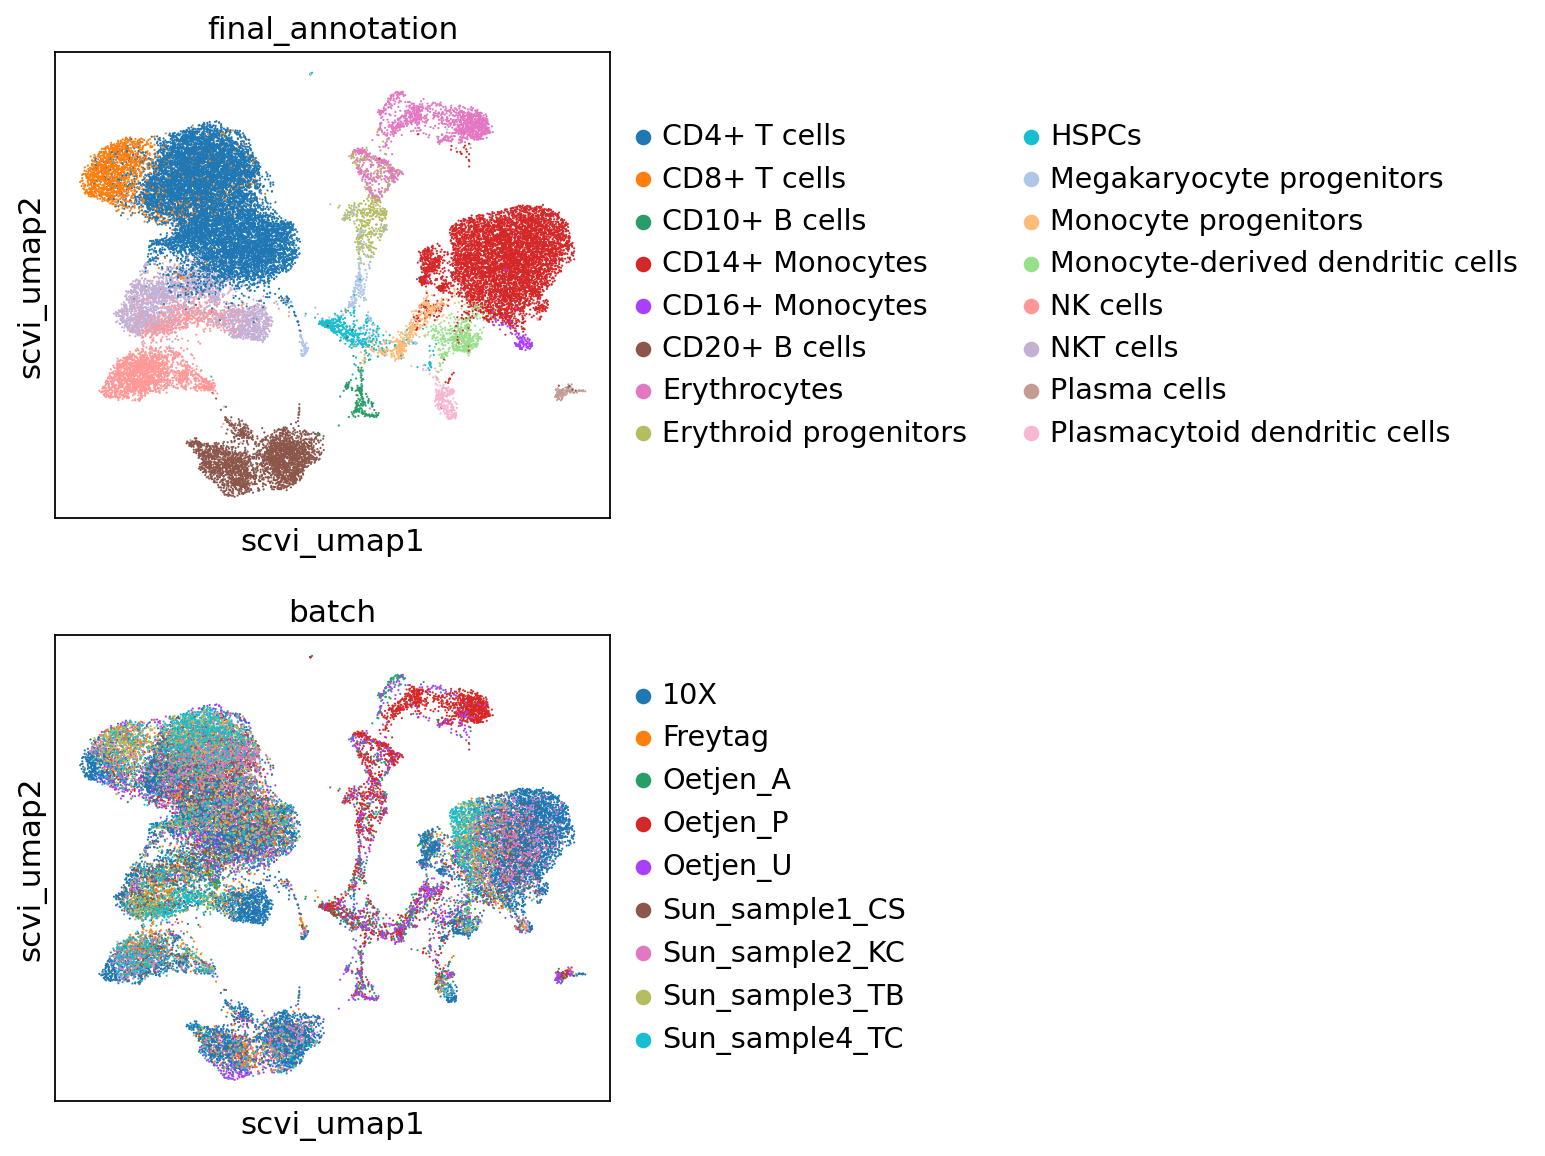

In [12]:
sc.pl.embedding(adata, basis="scvi_umap", color=["final_annotation", "batch"], ncols=1)

## Batch embeddings

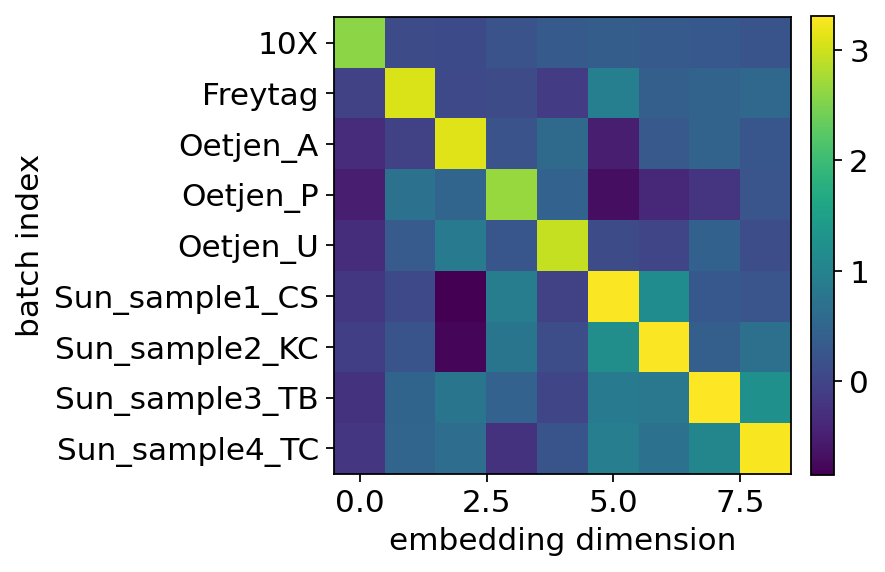

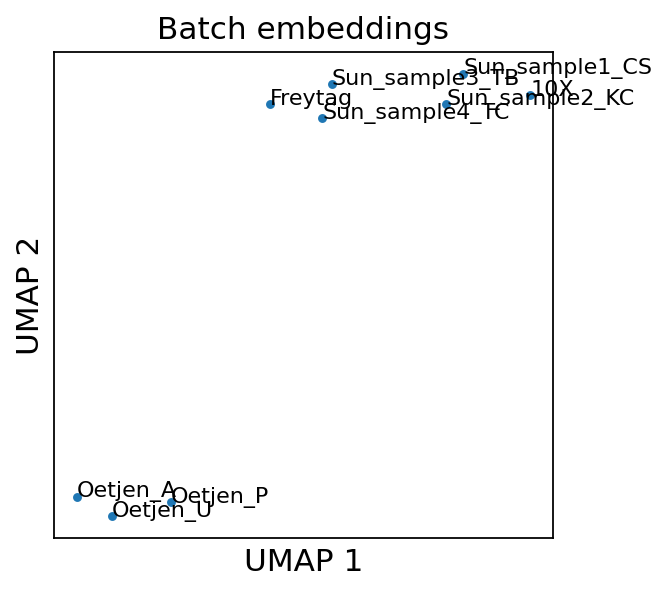

In [13]:
if config_dict["model"]["model"]["init_args"]["batch_embedded"]:
    # show batch embeddings as an image
    batch_key = config_dict["data"]["batch_keys"]["batch_index_n"]["key"]
    batch_names = adata.obs[batch_key].cat.categories
    plt.imshow(scvi_model.batch_representation_mean_bd.detach().cpu().numpy())
    plt.xlabel("embedding dimension")
    plt.yticks(ticks=range(len(batch_names)), labels=batch_names)
    plt.ylabel("batch index")
    plt.grid(False)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.show()

    # show batch embeddings as a umap
    um = umap.UMAP(n_neighbors=3, metric="cosine").fit_transform(
        scvi_model.batch_representation_mean_bd.detach().cpu().numpy()
    )
    plt.plot(um[:, 0], um[:, 1], ".")
    for x, y, s in zip(um[:, 0], um[:, 1], batch_names):
        plt.annotate(str(s), (x, y), fontsize=10)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title("Batch embeddings")
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.show()

else:
    print(
        "Model was run with `batch_embedded: false` in the config under model.model.init_args,"
        " so we did not learn an embedding of batch."
    )